In [1]:
import os
import sys
import casadi as cd
sys.path.append(os.path.abspath(os.path.dirname(os.getcwd())))
sys.path.append(os.path.abspath(os.getcwd()))
from Envs.pendulum import Pendulum_Env,Pendulum_Model
from Solvers.OCsolver import ocsolver_v2
from Solvers.Cutter import cutter_v2
from Solvers.MVEsolver import mvesolver
from utils.Correction import Correction_Agent
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def pendulum_eval(gamma=0.1):
    # get dynamics, set up step cost and terminal cost
    #0.05
    p_model=Pendulum_Model(10,1,1,0.4,0.02)

    P_matrix=np.array([[0.0,0],
                   [0,0.0]])
    T_matrix=np.array([[25,0],
                   [0,10]])



    dyn_func=p_model.get_dyn_f()
    step_func=p_model.get_step_cost(P_matrix,0.1)
    terminal_func=p_model.get_terminal_cost(T_matrix)

    # set up safety features
    Horizon=40
    Gamma=gamma
    def generate_phi():
            traj=cd.SX.sym('xi',3*Horizon + 2)
            phi=cd.vertcat(cd.DM(-3),traj[3:5])
            return cd.Function('phi',[traj],[phi])

    phi_func=generate_phi() #traj: [x,u,x,u,..,x] phi:[phi0, phi1, phi2]

    lbs=np.array([-2,-2]) #-6
    ubs=np.array([2,2])

    weights_init=(lbs+ubs)/2
    weights_H=np.array([0.6,1])

    #construct environment
    p_env=Pendulum_Env(10,1,1,0.4,0.02)
    p_env.set_init_state(np.array([0,0]))
    #p_env.set_noise(False)
    #construct correction agent
    agent=Correction_Agent('dummy')
    agent.set_state_dim(2)
    agent.set_ctrl_dim(1)
    agent.set_dyn(dyn_func)
    agent.set_step_cost(step_func)
    agent.set_term_cost(terminal_func)
    agent.set_g(phi_func,weights=weights_H,gamma=Gamma)
    #agent.set_threshold(-0.1) #-0.5
    agent.set_threshold(-1.0) #-0.5
    agent.set_p(0.3)
    agent.construct_graph(horizon=Horizon)

    #construct controller
    controller=ocsolver_v2('pendulum control')
    controller.set_state_param(2,[-2*np.pi,-100],[2*np.pi,100])
    controller.set_ctrl_param(1,[-1e10],[1e10])
    controller.set_dyn(dyn_func)
    controller.set_step_cost(step_func)
    controller.set_term_cost(terminal_func)
    #controller.construct_graph(horizon=Horizon)
    controller.set_g(phi_func,gamma=Gamma)
    controller.construct_prob(horizon=Horizon)

    #construct cutter
    hb_calculator=cutter_v2('pendulum cut')
    hb_calculator.from_controller(controller)
    hb_calculator.construct_graph(horizon=Horizon)

    #construct MVESolver
    mve_calc=mvesolver('pendulum_mve',2)

    mve_calc.set_init_constraint(lbs, ubs) #Theta_0

    learned_theta=np.array(weights_init)

    #learning logs
    theta_log=[np.array(weights_init)]
    error_log=[np.linalg.norm(weights_init-weights_H)]

    d_0,C_0=mve_calc.solve()
    v_0=np.log(np.linalg.det(C_0))
    volume_log=[v_0]

    EPISODE=0
    corr_num=0
    termination_flag=False
    while not termination_flag:
        #print('episode',EPISODE)
        # random init
        init_state=np.array([0.,0.])
        init_state[0] += np.random.uniform(0,2*np.pi/3)
        init_state[1] += np.random.uniform(0,3)
        p_env.set_init_state(init_state)
        for i in range(200):
            x=p_env.get_curr_state()
            if np.sqrt(np.sum((x-np.array([np.pi,0]))**2)) <=0.15:
                print('reached desired position')
                break
            #print(i)
            u=controller.control(x,weights=learned_theta)
            agent_output=agent.act(controller.opt_traj)
            if agent_output is None:
                #print('emergency stop')
                break
            elif type(agent_output)==bool:
                pass
            else:
                corr_num+=1
                h,b,h_phi,b_phi=hb_calculator.calc_planes(learned_theta,x,controller.opt_traj,np.sign(agent_output))
                #print('cutting plane calculated')
                #print('h',h)
                #print('b',b)
                #print('diff', h.T @ learned_theta - b)
                #print('h_phi',h_phi)
                #print('b_phi',b_phi)

                mve_calc.add_constraint(h,b[0])
                mve_calc.add_constraint(h_phi,b_phi[0])
                learned_theta,C=mve_calc.solve()
                #difference=np.linalg.norm(learned_theta-weights_H)
                difference=learned_theta-weights_H
                vol=np.log(np.linalg.det(C))
                #print('leanred safety param',learned_theta)
                theta_log.append(learned_theta)
                #print('difference', difference)
                error_log.append(np.linalg.norm(difference))
                #print('volume', vol)
                volume_log.append(vol)
                #mve_calc.draw(C,learned_theta,weights_H)
                #if np.max(np.abs(difference))<0.04:
                if np.linalg.norm(difference) < 0.02:
                    print("converged! Final Result: ",learned_theta)
                    termination_flag=True
                    break
                
                
            p_env.step(u)
        #p_env.show_animation()
        EPISODE+=1

    return theta_log, error_log, volume_log


In [3]:
theta_logs=[]
error_logs=[]
volume_logs=[]
lengths = []

In [4]:
avg_lengths = []
std_lengths = []
for gamma in [0.01,0.02,0.05,0.1,0.2,0.5,1.0,2.0,5.0,10.0]:
    theta_logs=[]
    error_logs=[]
    volume_logs=[]
    lengths = []
    eval_cnt=0
    while eval_cnt<20:
        print('eval num',eval_cnt)
        try:
            tmp_theta_log,tmp_error_log,tmp_volume_log=pendulum_eval(gamma)
            print('length',len(tmp_theta_log))
            lengths.append(len(tmp_theta_log))
            theta_logs.append(tmp_theta_log)
            error_logs.append(tmp_error_log)
            volume_logs.append(tmp_volume_log)
            eval_cnt+=1
        except:
            print("error")

    avg_lengths.append(np.mean(lengths))
    std_lengths.append(np.std(lengths))

eval num 0


CasADi - 2024-12-06 09:52:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58621682 1.00409095]
length 10
eval num 1
converged! Final Result:  [0.6015735  0.99252164]
length 15
eval num 2


CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60364859 0.99458494]
length 14
eval num 3


CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60372846 0.99930201]
length 16
eval num 4


CasADi - 2024-12-06 09:52:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.5878068 0.9937865]
length 11
eval num 5


CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59686418 0.99735963]
length 12
eval num 6


CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:21 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58771439 1.00961078]
length 14
eval num 7


CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58217568 0.99850871]
length 9
eval num 8


CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:22 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60068773 0.99493941]
length 15
eval num 9


CasADi - 2024-12-06 09:52:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.5931197  1.00213879]
length 8
eval num 10


CasADi - 2024-12-06 09:52:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60867121 0.99138727]
length 11
eval num 11


CasADi - 2024-12-06 09:52:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:23 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60920508 1.00071468]
length 12
eval num 12


CasADi - 2024-12-06 09:52:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:24 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.5988462  0.99896647]
length 10
eval num 13
converged! Final Result:  [0.60715111 0.98758281]
length 12
eval num 14


CasADi - 2024-12-06 09:52:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


error
eval num 14


CasADi - 2024-12-06 09:52:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.61054036 1.00111702]
length 9
eval num 15
error
eval num 15


CasADi - 2024-12-06 09:52:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.6034134  0.99777514]
length 10
eval num 16


CasADi - 2024-12-06 09:52:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:27 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59344342 0.99748069]
length 11
eval num 17
converged! Final Result:  [0.60243311 1.00483791]
length 7
eval num 18


CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.594327   1.00009205]
length 14
eval num 19


CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59028995 1.00661518]
length 8
eval num 0
error
eval num 0


CasADi - 2024-12-06 09:52:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.5916046 1.0015725]
length 15
eval num 1


CasADi - 2024-12-06 09:52:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60467801 0.99618019]
length 7
eval num 2
error
eval num 2


CasADi - 2024-12-06 09:52:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59818504 0.9998378 ]
length 10
eval num 3


CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59895358 1.01760765]
length 11
eval num 4


CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:31 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59791697 1.00442392]
length 12
eval num 5


CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

error
eval num 5


CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58578052 1.00123291]
length 9
eval num 6


CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58526469 1.00156899]
length 14
eval num 7


CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.61439248 1.00081858]
length 11
eval num 8


CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58772642 1.00243287]
length 15
eval num 9


CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58804448 1.00989107]
length 14
eval num 10


CasADi - 2024-12-06 09:52:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59376782 1.0013586 ]
length 15
eval num 11


CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58761688 0.98936903]
length 9
eval num 12


CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58263917 1.00155513]
length 11
eval num 13


CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59198767 1.01463583]
length 12
eval num 14
converged! Final Result:  [0.60197743 1.00071204]
length 14
eval num 15


CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60252115 1.00779696]
length 7
eval num 16


CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60329539 0.98669225]
length 11
eval num 17


CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58948716 0.9992375 ]
length 13
eval num 18
error
eval num 18


CasADi - 2024-12-06 09:52:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:39 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59692489 1.00227496]
length 17
eval num 19


CasADi - 2024-12-06 09:52:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:40 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

error
eval num 19


CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.61294803 0.9875024 ]
length 13
eval num 0


CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:41 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59501761 0.99171039]
length 12
eval num 1


CasADi - 2024-12-06 09:52:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60895805 0.98921095]
length 12
eval num 2


CasADi - 2024-12-06 09:52:42 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.5838725  1.01140526]
length 10
eval num 3


CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60079169 0.99378987]
length 15
eval num 4


CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

error
eval num 4
converged! Final Result:  [0.6000477  0.99728323]
length 11
eval num 5


CasADi - 2024-12-06 09:52:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59657387 0.98519028]
length 11
eval num 6


CasADi - 2024-12-06 09:52:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60475219 0.99799397]
length 11
eval num 7


CasADi - 2024-12-06 09:52:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:46 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.61867003 1.00021804]
length 11
eval num 8
error
eval num 8


CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

error
eval num 8


CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:47 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59757295 1.00087695]
length 13
eval num 9


CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58332111 1.00543369]
length 11
eval num 10


CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58715729 0.98830443]
length 8
eval num 11


CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:48 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58567404 0.98974092]
length 12
eval num 12


CasADi - 2024-12-06 09:52:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60274508 0.99527713]
length 14
eval num 13


CasADi - 2024-12-06 09:52:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:49 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59569668 0.99485332]
length 9
eval num 14
converged! Final Result:  [0.58686422 1.00351008]
length 11
eval num 15


CasADi - 2024-12-06 09:52:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:50 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

error
eval num 15


CasADi - 2024-12-06 09:52:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:51 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.5986065  0.99161684]
length 13
eval num 16
error
eval num 16


CasADi - 2024-12-06 09:52:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:52 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58339746 0.99876694]
length 10
eval num 17
converged! Final Result:  [0.60154399 0.98650566]
length 9
eval num 18


CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58799567 1.00742821]
length 10
eval num 19


CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:53 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60401166 0.99228339]
length 17
eval num 0


CasADi - 2024-12-06 09:52:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:54 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58515015 1.01282003]
length 16
eval num 1
error
eval num 1


CasADi - 2024-12-06 09:52:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:55 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60615543 1.00071929]
length 11
eval num 2
converged! Final Result:  [0.60223392 0.99862253]
length 12
eval num 3
converged! Final Result:  [0.59881673 1.00460299]
length 13
eval num 4
converged! Final Result:  [0.59808858 0.9988049 ]
length 15
eval num 5


CasADi - 2024-12-06 09:52:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:57 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58278609 1.00400167]
length 11
eval num 6


CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60662632 0.99552329]
length 16
eval num 7


CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60355703 1.00031877]
length 14
eval num 8


CasADi - 2024-12-06 09:52:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:52:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59127602 1.00501802]
length 14
eval num 9


CasADi - 2024-12-06 09:52:59 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


error
eval num 9


CasADi - 2024-12-06 09:53:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:00 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60590332 0.98709594]
length 15
eval num 10
converged! Final Result:  [0.59391899 0.99963502]
length 13
eval num 11


CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.58810604 0.99961934]
length 11
eval num 12


CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:01 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59987341 1.0022881 ]
length 13
eval num 13


CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:02 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.5974931  0.99987641]
length 16
eval num 14
converged! Final Result:  [0.59868976 0.99929174]
length 13
eval num 15


CasADi - 2024-12-06 09:53:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:03 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60979457 1.00144275]
length 12
eval num 16


CasADi - 2024-12-06 09:53:04 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59820767 1.00415836]
length 14
eval num 17


CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59489994 0.99944549]
length 12
eval num 18


CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59652598 0.98448698]
length 8
eval num 19
converged! Final Result:  [0.60867446 0.99898027]
length 10
eval num 0


CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:05 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60122971 0.99697068]
length 17
eval num 1
converged! Final Result:  [0.60603845 0.99492699]
length 9
eval num 2


CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.5878715  1.00180567]
length 15
eval num 3


CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:07 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

error
eval num 3


CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59585953 1.00079042]
length 14
eval num 4


CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:08 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60011565 0.99239351]
length 13
eval num 5


CasADi - 2024-12-06 09:53:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58020062 0.99726967]
length 13
eval num 6


CasADi - 2024-12-06 09:53:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:09 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60550775 0.99080609]
length 16
eval num 7


CasADi - 2024-12-06 09:53:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.59847882 1.0001614 ]
length 13
eval num 8


CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.6085901  1.00344629]
length 11
eval num 9


CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:11 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60835419 0.9877261 ]
length 10
eval num 10
converged! Final Result:  [0.60265038 1.00415452]
length 10
eval num 11
converged! Final Result:  [0.58657896 0.99210111]
length 8
eval num 12
converged! Final Result:  [0.60980958 0.9843814 ]
length 13
eval num 13


CasADi - 2024-12-06 09:53:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:13 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60888671 0.99752081]
length 15
eval num 14
converged! Final Result:  [0.59019766 0.99920553]
length 8
eval num 15


CasADi - 2024-12-06 09:53:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:14 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58628029 1.00441821]
length 13
eval num 16


CasADi - 2024-12-06 09:53:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58491813 0.988625  ]
length 11
eval num 17


CasADi - 2024-12-06 09:53:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59623466 1.00343828]
length 14
eval num 18


CasADi - 2024-12-06 09:53:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.61840066 0.99263611]
length 8
eval num 19


CasADi - 2024-12-06 09:53:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:16 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60134263 1.00401589]
length 13
eval num 0
converged! Final Result:  [0.59568845 1.00043226]
length 11
eval num 1
converged! Final Result:  [0.59479283 1.00415144]
length 14
eval num 2
error
eval num 2


CasADi - 2024-12-06 09:53:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60298746 0.99696108]
length 11
eval num 3


CasADi - 2024-12-06 09:53:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58647973 1.00447488]
length 11
eval num 4
converged! Final Result:  [0.60283328 1.00454606]
length 11
eval num 5
converged! Final Result:  [0.60873179 1.00008041]
length 12
eval num 6
converged! Final Result:  [0.59096053 1.01683693]
length 13
eval num 7
converged! Final Result:  [0.59963981 1.00230316]
length 14
eval num 8
converged! Final Result:  [0.60841415 0.98358433]
length 14
eval num 9
converged! Final Result:  [0.60327343 0.99577186]
length 14
eval num 10
converged! Final Result:  [0.59537002 1.00647111]
length 14
eval num 11
converged! Final Result:  [0.58500211 1.00069102]
length 11
eval num 12
converged! Final Result:  [0.61253494 0.99356056]
length 14
eval num 13
converged! Final Result:  [0.59259156 1.00620223]
length 12
eval num 14
converged! Final Result:  [0.58979732 1.00664742]
length 11
eval num 15
error
eval num 15
error
eval num 15
converged! Final Result:  [0.60625054 1.0026574 ]
length 10
eval num 16


CasADi - 2024-12-06 09:53:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).")

converged! Final Result:  [0.60799488 0.98408801]
length 14
eval num 17


CasADi - 2024-12-06 09:53:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:26 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.5989183 0.9968291]
length 15
eval num 18
error
eval num 18
converged! Final Result:  [0.58807289 1.01537084]
length 13
eval num 19
converged! Final Result:  [0.59924964 1.00159885]
length 14
eval num 0
converged! Final Result:  [0.61444522 0.98944197]
length 7
eval num 1
converged! Final Result:  [0.60529192 0.99248497]
length 14
eval num 2


CasADi - 2024-12-06 09:53:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:29 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60256647 0.98965037]
length 11
eval num 3
converged! Final Result:  [0.60327236 0.98270213]
length 13
eval num 4
converged! Final Result:  [0.60677718 1.01432516]
length 10
eval num 5


CasADi - 2024-12-06 09:53:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:30 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59916927 1.00017808]
length 11
eval num 6
converged! Final Result:  [0.59785162 0.99769191]
length 13
eval num 7
converged! Final Result:  [0.60782614 0.99931733]
length 10
eval num 8
converged! Final Result:  [0.60668208 0.99546413]
length 14
eval num 9
error
eval num 9


CasADi - 2024-12-06 09:53:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.61163723 0.99114206]
length 13
eval num 10
converged! Final Result:  [0.5924359 1.0025981]
length 15
eval num 11
converged! Final Result:  [0.59290062 1.0135619 ]
length 14
eval num 12
error
eval num 12


CasADi - 2024-12-06 09:53:34 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60960888 0.99820496]
length 13
eval num 13


CasADi - 2024-12-06 09:53:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:35 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


error
eval num 13
converged! Final Result:  [0.59178061 1.008692  ]
length 12
eval num 14


CasADi - 2024-12-06 09:53:36 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60092826 0.99037402]
length 14
eval num 15


CasADi - 2024-12-06 09:53:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59030097 1.00630365]
length 14
eval num 16


CasADi - 2024-12-06 09:53:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:37 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59995881 1.00269643]
length 15
eval num 17
converged! Final Result:  [0.59182608 1.00224438]
length 14
eval num 18


CasADi - 2024-12-06 09:53:38 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59791872 1.0002114 ]
length 14
eval num 19
converged! Final Result:  [0.59315077 0.98896434]
length 11
eval num 0
converged! Final Result:  [0.59736779 0.99763755]
length 10
eval num 1
error
eval num 1
converged! Final Result:  [0.59236438 1.00876883]
length 14
eval num 2
converged! Final Result:  [0.60999719 0.98984845]
length 13
eval num 3
converged! Final Result:  [0.61622802 0.99039707]
length 10
eval num 4
converged! Final Result:  [0.58715554 1.01312387]
length 11
eval num 5
error
eval num 5
converged! Final Result:  [0.59522404 1.00671531]
length 15
eval num 6


CasADi - 2024-12-06 09:53:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:43 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58936412 0.99365409]
length 10
eval num 7
converged! Final Result:  [0.59938446 0.99638135]
length 13
eval num 8
converged! Final Result:  [0.61463557 0.99387514]
length 13
eval num 9
converged! Final Result:  [0.60566675 0.99417238]
length 15
eval num 10


CasADi - 2024-12-06 09:53:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:53:45 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.59302052 0.99477387]
length 12
eval num 11
converged! Final Result:  [0.61773317 0.99298612]
length 10
eval num 12
error
eval num 12
converged! Final Result:  [0.59741078 0.98368552]
length 8
eval num 13
converged! Final Result:  [0.59928804 1.01723094]
length 12
eval num 14
converged! Final Result:  [0.60369079 0.99349985]
length 11
eval num 15
error
eval num 15
converged! Final Result:  [0.60210248 0.99764151]
length 14
eval num 16
converged! Final Result:  [0.60337916 1.01333493]
length 11
eval num 17
error
eval num 17
converged! Final Result:  [0.59236454 1.00389319]
length 13
eval num 18
converged! Final Result:  [0.59376472 0.99087738]
length 8
eval num 19
converged! Final Result:  [0.59959854 1.00314208]
length 15
eval num 0
converged! Final Result:  [0.60295879 0.99267695]
length 15
eval num 1
converged! Final Result:  [0.60063802 1.01653202]
length 9
eval num 2
converged! Final Result:  [0.59359736 1.01424453]
length 14
eval num 3
converged! Final 

CasADi - 2024-12-06 09:53:58 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.5935636  1.00880145]
length 15
eval num 12
converged! Final Result:  [0.60310787 0.99049295]
length 12
eval num 13
converged! Final Result:  [0.60973631 0.98744432]
length 14
eval num 14
converged! Final Result:  [0.6142924  0.98609307]
length 14
eval num 15
converged! Final Result:  [0.59513558 1.00351417]
length 13
eval num 16
converged! Final Result:  [0.59551247 0.99492838]
length 11
eval num 17
converged! Final Result:  [0.59509435 1.00673563]
length 12
eval num 18
converged! Final Result:  [0.60004117 1.00235563]
length 15
eval num 19
error
eval num 19
converged! Final Result:  [0.61083521 0.99159339]
length 16
eval num 0
converged! Final Result:  [0.58821672 1.00772204]
length 13
eval num 1
converged! Final Result:  [0.58866625 1.01011444]
length 14
eval num 2
converged! Final Result:  [0.5871456  1.00661183]
length 17
eval num 3
converged! Final Result:  [0.60059814 1.00276416]
length 14
eval num 4
converged! Final Result:  [0.59561333 1.00543282]
l

CasADi - 2024-12-06 09:54:10 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:54:15 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:54:18 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:54:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:54:19 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.58837063 1.00788643]
length 13
eval num 8
converged! Final Result:  [0.61684605 0.99724924]
length 7
eval num 9


CasADi - 2024-12-06 09:54:20 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60639295 0.99306153]
length 14
eval num 10
converged! Final Result:  [0.58936837 1.00889983]
length 15
eval num 11
converged! Final Result:  [0.59169982 1.01740162]
length 11
eval num 12


CasADi - 2024-12-06 09:54:25 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


converged! Final Result:  [0.60240995 0.9834216 ]
length 10
eval num 13


CasADi - 2024-12-06 09:54:28 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


error
eval num 13
converged! Final Result:  [0.58905652 1.00754977]
length 14
eval num 14
converged! Final Result:  [0.59066478 1.00874122]
length 15
eval num 15
converged! Final Result:  [0.60036964 1.00734862]
length 11
eval num 16
converged! Final Result:  [0.60202806 0.99452637]
length 13
eval num 17


CasADi - 2024-12-06 09:54:32 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-12-06 09:54:33 WARNING("solver:nlp_f failed: NaN detected for output f, at (row 0, col 0).") [.../casadi/core/oracle_function.cpp:377]


error
eval num 17
converged! Final Result:  [0.59193683 0.99394196]
length 12
eval num 18
converged! Final Result:  [0.61762382 0.99737617]
length 12
eval num 19
converged! Final Result:  [0.59802764 1.00161092]
length 15


In [5]:
avg_lengths

[11.4, 12.0, 11.5, 12.95, 12.2, 12.65, 12.6, 11.9, 12.3, 13.0]

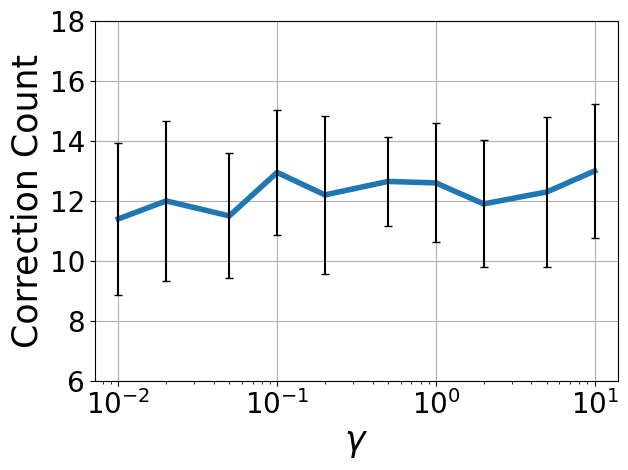

In [7]:
gamma_list = [0.01,0.02,0.05,0.1,0.2,0.5,1.0,2.0,5.0,10.0]
plt.figure()
#plt.title("Correction Number VS $\gamma$",fontsize=20)
plt.grid()
plt.plot(gamma_list,avg_lengths,linewidth=4)
plt.errorbar(gamma_list, avg_lengths, yerr=std_lengths, capsize=3, fmt="none", ecolor = "black",markersize = 5)
plt.xscale('log')
plt.xlabel("$\gamma$",fontsize=25)
plt.ylabel("Correction Count",fontsize=25)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim(6,18)
plt.tight_layout()
plt.savefig('../Data/ablation/gamma.jpg')
plt.show()
